In [3]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 1. Load Dataset

In [26]:
df = pd.read_csv('./data/final_0509.csv')
# 한국 일일확진자 변수 제거
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [27]:
for i in list(df.columns):
    if i[0:2] == 'KR':
        print(i)

KR


In [28]:
df.tail()

,Date,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,...,DE_roam,JP_roam,TH_roam,VN_roam,US_roam,CN_roam,news,covid_tr,coro_tr,target
100,2020-05-01,0,0,476,284,7933,6,0,34037,557,...,6,119,32,58,108,196,1104.0,48.0,18.0,8.0
101,2020-05-02,0,0,445,156,9623,13,3,29078,561,...,26,158,15,17,132,84,732.0,43.0,18.0,8.0
102,2020-05-03,4,0,335,295,10633,8,4,25501,564,...,18,142,22,52,92,121,821.0,55.0,18.0,10.0
103,2020-05-04,6,0,199,262,10581,3,2,22335,567,...,30,122,6,91,66,88,1331.0,30.0,17.0,8.0
104,2020-05-05,0,0,318,199,10102,2,0,23976,462,...,18,161,26,49,123,94,793.0,30.0,17.0,3.0


## lag 변수 생성

In [29]:
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)

In [30]:
lag_col= list(df.columns)

In [31]:
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
    
df.dropna(inplace=True)

# 2. Load Model

In [32]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return res

In [33]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

In [43]:
# 모델 불러오기
PATH = './models/81.72_n_features_331_n_hidden_64_n_layers_4_lr_0.0001_seq_length_1_num_epochs_200.pth'
model = torch.load(PATH)
model.eval()

CoronaVirusPredictor(
  (lstm): LSTM(331, 64, num_layers=4)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

# 3. Predicting future cases

In [44]:
X_cols = list(df.columns)
X_cols.remove('target')

In [45]:
# X변수들과 y변수 구분
X_all = df[X_cols]
y_all = df['target']

In [46]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [47]:
y_all

array([0.      , 0.015625, 0.015625, 0.      , 0.      , 0.03125 ,
       0.015625, 0.015625, 0.03125 , 0.      , 0.015625, 0.03125 ,
       0.03125 , 0.      , 0.      , 0.      , 0.      , 0.015625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.265625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.015625, 0.      , 0.      ,
       0.015625, 0.015625, 0.015625, 0.03125 , 0.03125 , 0.0625  ,
       0.046875, 0.03125 , 0.      , 0.015625, 0.0625  , 0.15625 ,
       0.21875 , 0.109375, 0.34375 , 0.234375, 0.328125, 0.421875,
       0.875   , 0.890625, 0.390625, 0.84375 , 0.765625, 1.      ,
       0.65625 , 0.65625 , 0.640625, 0.71875 , 0.640625, 0.828125,
       0.4375  , 0.515625, 0.46875 , 0.453125, 0.125   , 0.265625,
       0.40625 , 0.265625, 0.171875, 0.234375, 0.1875  , 0.25    ,
       0.15625 , 0.078125, 0.125   , 0.078125, 0.09375 , 0.062

In [48]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (102, 331)
y_all :  (102,)


In [49]:
# 시퀀스 길이
seq_length = 1

X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [50]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [51]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [52]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
predicted_cases=pred_values_ceiled
predicted_cases

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

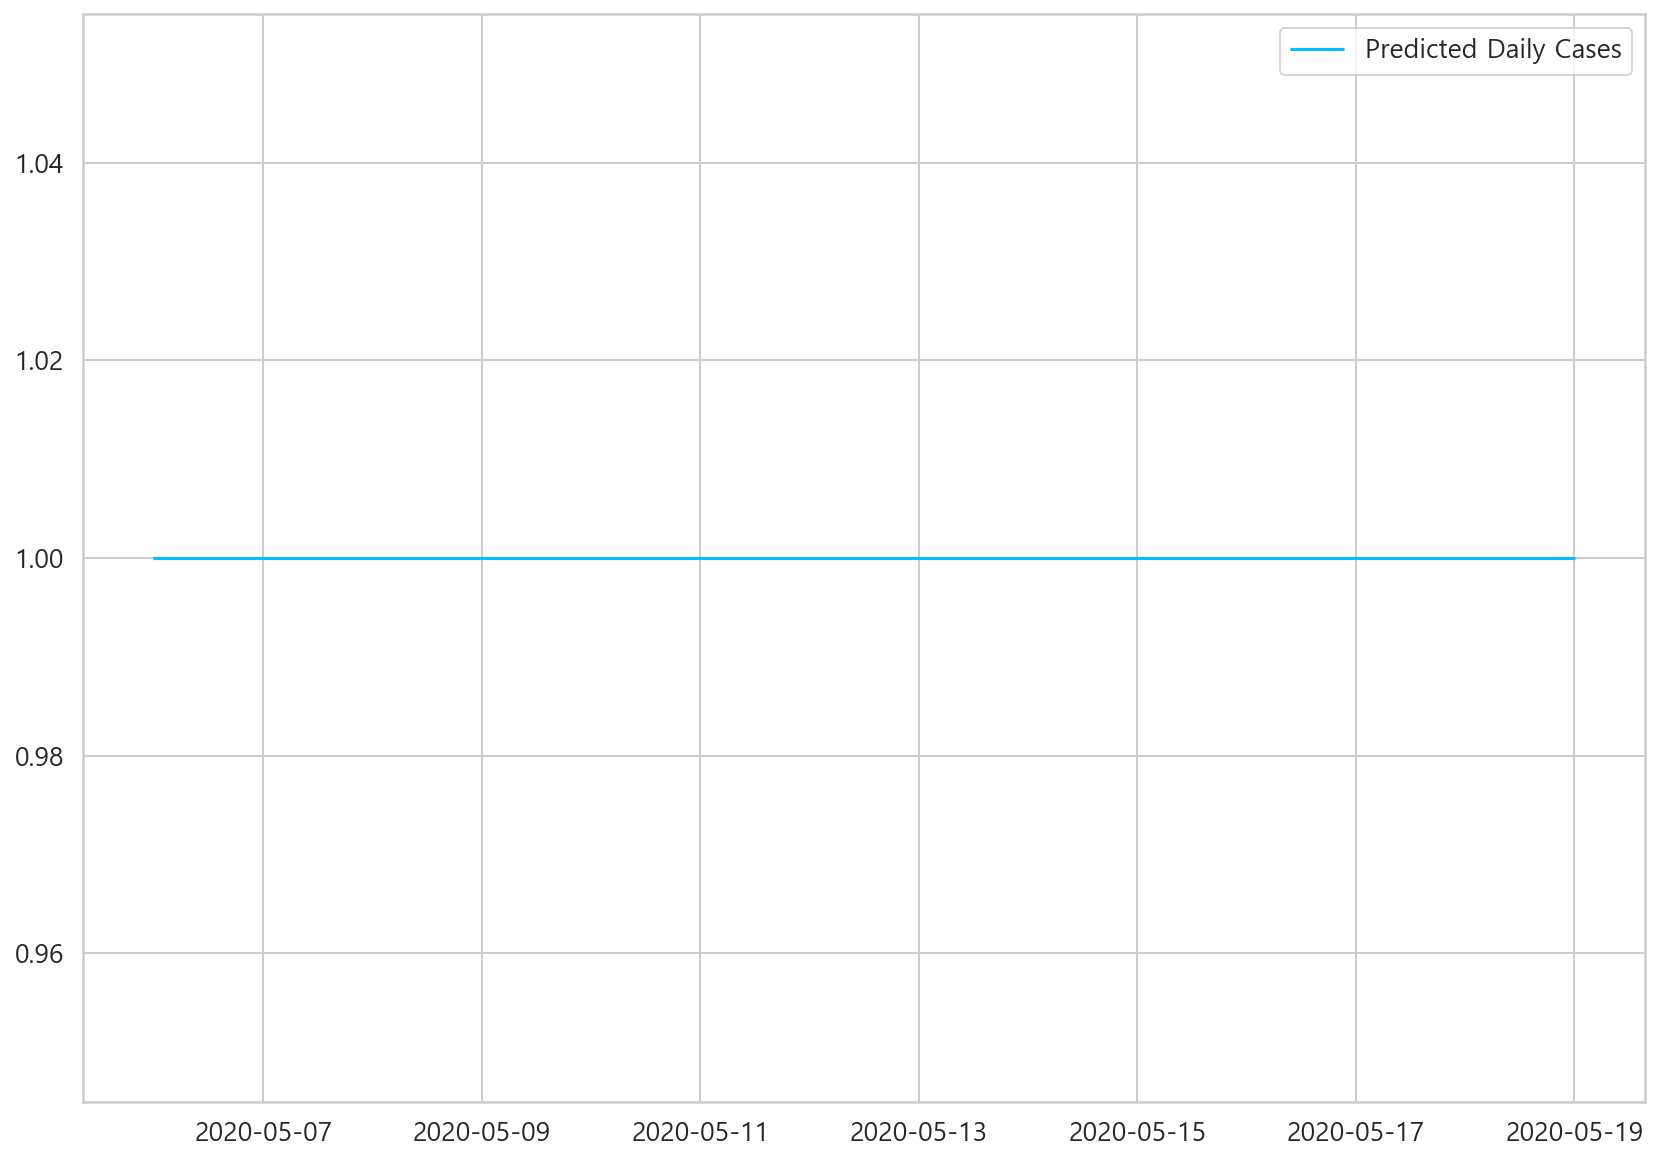

In [53]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [54]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [55]:
preds_

,0
2020-05-06,1
2020-05-07,1
2020-05-08,1
2020-05-09,1
2020-05-10,1
2020-05-11,1
2020-05-12,1
2020-05-13,1
2020-05-14,1
2020-05-15,1


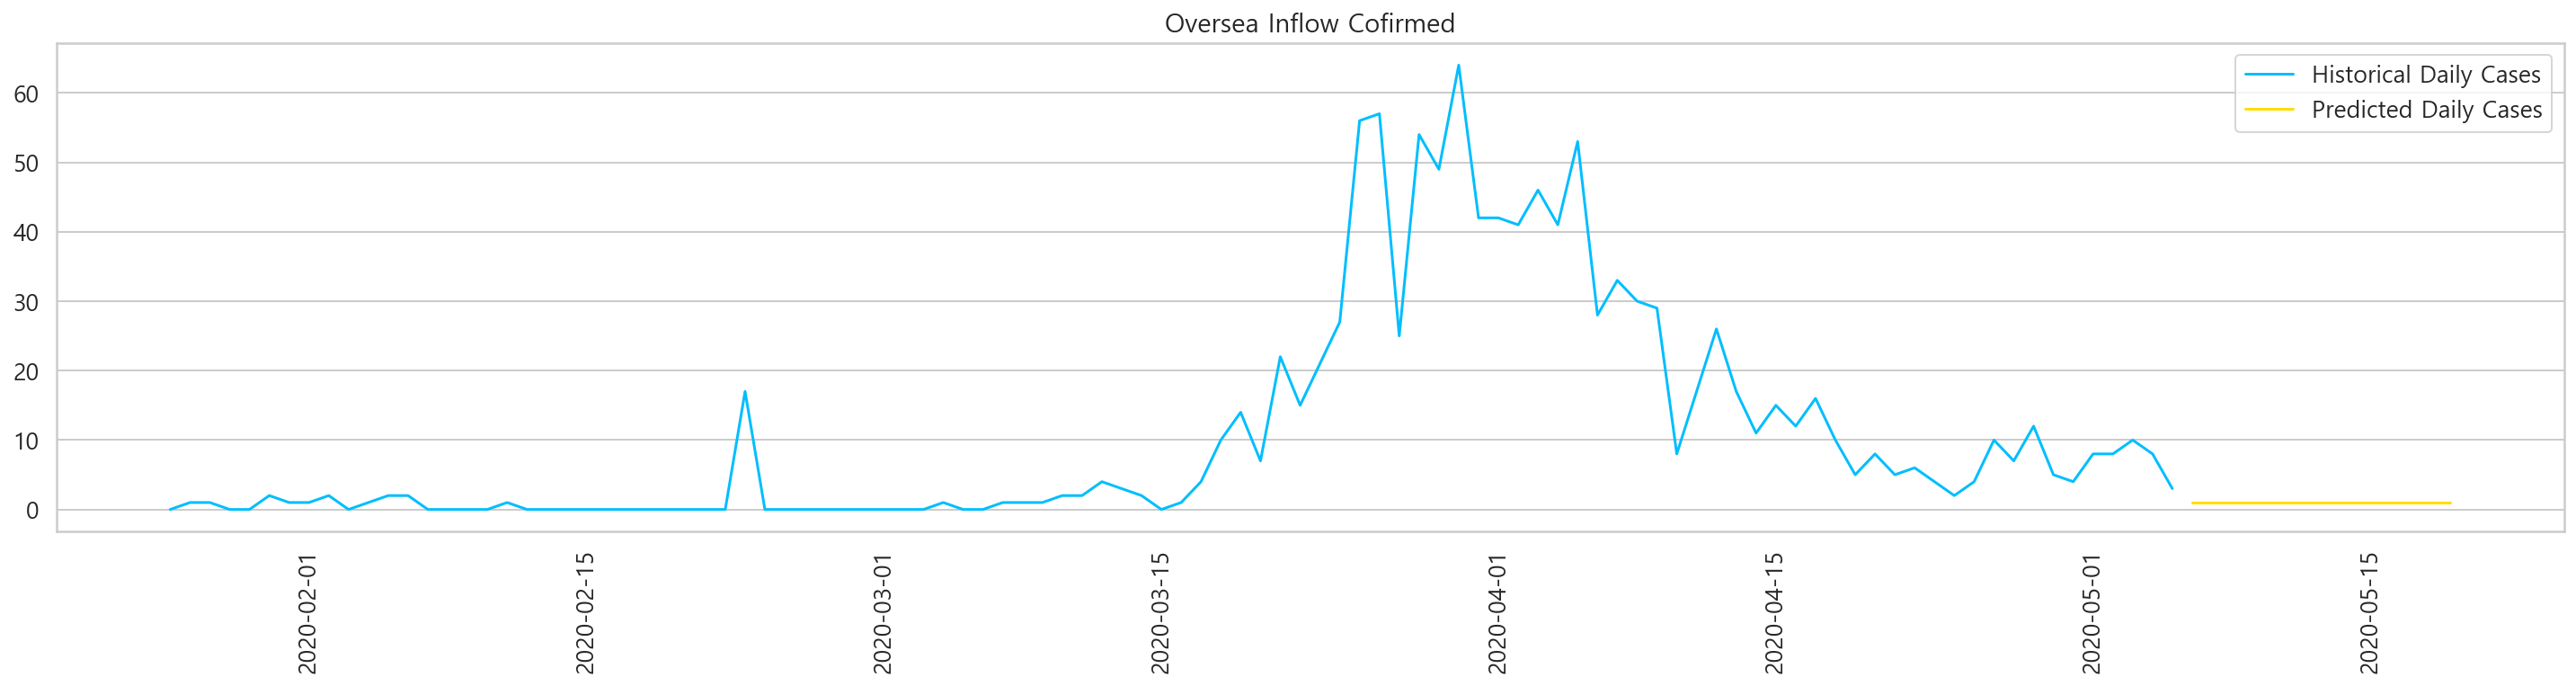

In [56]:
plt.figure(figsize=(25,5))
plt.plot(df['target'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();